In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

class UnionFind:
    """简单的并查集，用于判断节点连通情况"""
    def __init__(self, n):
        self.parent = list(range(n))
    
    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x
    
    def union(self, x, y):
        rx = self.find(x)
        ry = self.find(y)
        if rx != ry:
            self.parent[ry] = rx

    
class Agent:
    """
    FirefightingAgent 是用于山火模拟中的 RL agent。
    ### 状态空间 (State Space)
    状态 sₜ 由两部分组成：
      1. 图状态 gₜ = (Vₜ, E, Bₜ)
         - Vₜ: 各区域的节点特征字典。对于每个节点，其特征包括：
               [current H, pos, max_health, region_discount_rate, ARC, current K]
         - E: 区域之间的边列表（时间不变），直接取自模拟中的边列表。
         - Bₜ: 环境外部信息，在时刻 t 的值，如 [wind_angle, wind_direction, wind_strength, dryness, temperature]
      2. Agent 状态 asₜ: 资源 J，即消防飞机数量（一个常数，不随时间变化）。"""
    
    def __init__(self):
        self.J = 10
        self.capability = 10 
        
    def get_state(self, simulation):
        """
        从 simulation 中提取当前状态。
        参数:
          simulation: 模拟环境对象，假定其 history 属性中保存了所有时刻的状态记录，
                      其中每条记录为 (t, env_factors, state, action)；state 为节点字典。
        返回:
          state: 一个元组 (graph_state, agent_state) 其中：
            - graph_state = (Vₜ, E, Bₜ)
                Vₜ: 当前时刻所有节点的状态字典，
                E: simulation 中的边列表，
                Bₜ: 当前时刻的环境外部信息 env_factors
            - agent_state: 即消防飞机数量 self.J
        """
        # 如果最后一条记录为 'end' 则取倒数第二条，否则取最后一条
        if simulation.history[-1] == 'end':
            current_record = simulation.history[-2]
        else:
            current_record = simulation.history[-1]
        _, env_factors, state = current_record
        Vt = state
        E = simulation.edges  # 边列表为时间不变的 E
        Bt = env_factors      # 当前环境外部信息
        graph_state = (Vt, E, Bt)
        agent_state = self.J
        return (graph_state, agent_state)

    def action(self, graph_state):
        #graph_state: [[env_vectors], [X_invariant], [X_variant], adjacency]
        Bt, Vt, X, E= graph_state
        nV = len(X)
        action = np.array([1.0 / nV for _ in range(nV)])
        print(action)
        return action

    def update_policy(self, reward, next_state):
        """
        策略更新接口（占位函数）。
        根据收到的奖励和下一个状态对内部策略进行更新。
        此处可结合具体 RL 算法（如 Q-learning, Policy Gradient 等）实现更新逻辑。
        目前该方法仅作为占位，不做任何更新。
        """
        pass

    def act(self, simulation):
        """
        综合 get_state 和 choose_action，根据当前 simulation 状态返回一个动作。
        
        参数:
          simulation: 模拟环境对象
        
        返回:
          action: 分配给每个节点的飞机分配权重列表。
        """
        state = self.get_state(simulation)
        action = self.choose_action(state)
        return action


class Region:
    def __init__(self, id, pos, H, region_discount_rate, ARC):
        """
        参数：
          id: 区域编号
          pos: 区域在二维平面上的位置 (x, y)
          H: 燃料量（血量），取值 100～1000
          region_discount_rate: 区域自然衰减的折扣率（0～1）
          ARC: 面积（公顷）
        """
        self.id = id
        self.pos = np.array(pos)
        self.H = H
        self.max_health = H
        self.region_discount_rate = region_discount_rate
        self.ARC = ARC
        self.K = 0.0  # 火焰强度初始为 0
        # 定义燃烧系数，设定常数 c（这里取 0.001），使得燃烧系数 = c * ARC
        self.transmisive = 1.5

    @property
    def active(self):
        """如果区域尚未烧尽，则返回 1，否则 0"""
        return 1 if self.H > 0 else 0

    def pos_vector(self):
        #return a standarized position vector
        return 0

class Edge:
    def __init__(self, region1, region2, border_direction, shared_border_area):
        """
        表示两个区域之间的接壤关系
        参数：
          region1, region2: 相邻的两个 Region 对象
          border_direction: 接壤朝向（一个二维单位向量），这里约定为从 region1 指向 region2
          shared_border_area: 接壤面积，取两区域面积平方根的较小值
        """
        self.region1 = region1
        self.region2 = region2
        self.border_direction = border_direction  # np.array，形状 (2,)
        self.shared_border_area = shared_border_area

class WildfireSimulation:
    def __init__(self, num_regions=10):
        self.num_regions = num_regions
        self.nodes = {}      # {region id: Region}
        self.edges = []      # Edge 列表
        self.adjacency = {}  # 邻接表：{region id: [(neighbor_id, Edge), ...]}
        self.history = []    # 记录每个时间步的状态: (t, env_factors, state)
        self.gamma = 0.9     # 折扣率（用于火焰传播中描述自身衰减）
        
        self.init_regions()
        self.init_edges()      # 保证生成的 graph 是 fully connected 的
        self.init_adjacency()
        
        # 指定火源（起火源）节点，默认为节点 0，并预先点燃
        self.fire_origin = 0
        self.nodes[self.fire_origin].K = 50.0

        self.agent = Agent()

    def init_regions(self):
        """随机生成区域及其属性"""
        for i in range(self.num_regions):
            pos = (random.uniform(0, 100), random.uniform(0, 100))
            H = random.uniform(600, 1000)
            region_discount_rate = 0.2
            ARC = random.uniform(1, 10)  # 假设面积在 1～10 公顷之间
            self.nodes[i] = Region(i, pos, H, region_discount_rate, ARC)

    def init_edges(self):
        """
        根据区域在平面上的位置，若两区域中心距离小于阈值，则认为它们相邻，建立边。
        为了保证 graph 是 fully connected 的，我们先按阈值生成边，
        然后利用并查集判断连通性，若存在不连通部分，再从所有可能的节点对中按距离最小的顺序依次添加边，
        直到整个 graph 连通。
        """
        self.edges = []
        node_ids = list(self.nodes.keys())
        threshold = 30.0  # 邻近判断阈值
        
        # 根据阈值生成初始的边
        for i in range(len(node_ids)):
            for j in range(i+1, len(node_ids)):
                node_i = self.nodes[node_ids[i]]
                node_j = self.nodes[node_ids[j]]
                dist = np.linalg.norm(node_i.pos - node_j.pos)
                if dist < threshold:
                    direction = node_j.pos - node_i.pos
                    if np.linalg.norm(direction) != 0:
                        border_direction = direction / np.linalg.norm(direction)
                    else:
                        border_direction = np.array([1.0, 0.0])
                    shared_border_area = min(math.sqrt(node_i.ARC), math.sqrt(node_j.ARC))
                    self.edges.append(Edge(node_i, node_j, border_direction, shared_border_area))
        
        # 利用并查集检查当前 graph 的连通性
        uf = UnionFind(self.num_regions)
        for edge in self.edges:
            uf.union(edge.region1.id, edge.region2.id)
        
        # 将所有节点对按距离从小到大排序
        all_pairs = []
        for i in range(len(node_ids)):
            for j in range(i+1, len(node_ids)):
                node_i = self.nodes[node_ids[i]]
                node_j = self.nodes[node_ids[j]]
                dist = np.linalg.norm(node_i.pos - node_j.pos)
                all_pairs.append((dist, node_ids[i], node_ids[j]))
        all_pairs.sort(key=lambda x: x[0])
        
        # 如果有不连通的部分，依次添加最小距离边，直到所有节点都连通
        for dist, i, j in all_pairs:
            if uf.find(i) != uf.find(j):
                node_i = self.nodes[i]
                node_j = self.nodes[j]
                direction = node_j.pos - node_i.pos
                if np.linalg.norm(direction) != 0:
                    border_direction = direction / np.linalg.norm(direction)
                else:
                    border_direction = np.array([1.0, 0.0])
                shared_border_area = min(math.sqrt(node_i.ARC), math.sqrt(node_j.ARC))
                self.edges.append(Edge(node_i, node_j, border_direction, shared_border_area))
                uf.union(i, j)

    def init_adjacency(self):
        """建立邻接表，每个区域记录所有相邻区域及对应边信息"""
        for node_id in self.nodes:
            self.adjacency[node_id] = []
        for edge in self.edges:
            id1 = edge.region1.id
            id2 = edge.region2.id
            self.adjacency[id1].append((id2, edge))
            self.adjacency[id2].append((id1, edge))

    # def run_session_MC(self, steps=10):
    #     # 记录初始状态（t=0）
    #     initial_env = {
    #         'wind_direction': None,
    #         'wind_strength': None,
    #         'dryness': None,
    #         'temperature': None
    #     }
    #     state = {node_id: {'pos': node.pos.copy(), 'H': node.H, 'K': node.K}
    #              for node_id, node in self.nodes.items()}
    #     self.history.append((0, initial_env, state))
        
    #     # 从 t=1 开始模拟
    #     for t in range(1, steps+1):
    #         print(f"--------------------------------{t}---------------------------")
    #         wind_angle = random.uniform(0, 2*math.pi)
    #         wind_direction = np.array([math.cos(wind_angle), math.sin(wind_angle)])
    #         wind_strength = random.uniform(0, 1)
    #         dryness = 1.5
    #         temperature = random.uniform(0, 1)
    #         env_factors = {
    #             'wind_direction': wind_direction,
    #             'wind_strength': wind_strength,
    #             'dryness': dryness,
    #             'temperature': temperature
    #         }
            
    #         factor = 0.5*(dryness + temperature)
            
    #         new_K = {}
    #         for node_id, node in self.nodes.items():
    #             # 如果本区域 H 已为 0，则不再传播
    #             if node.H < 0:
    #                 print(f"node {node_id} stop transimission")
    #                 new_K[node_id] = 0.0
    #                 node.H = 0
    #                 print(new_K[node_id], node.H)
    #             else:
    #                 # retention = node.active * (node.K + node.transmisive*node.K*(node.max_health-node.K)/node.max_health - node.region_discount_rate*node.K)        #!!!!!!!!!!!!要复合内部人口疾病传播的模型，是类似于指数的情况
    #                 retention = node.active * node.transmisive * node.K
    #                 incoming = 0.0
    #                 outgoing = 0.0
                    
    #                 for (nbr_id, edge) in self.adjacency[node_id]:
    #                     neighbor = self.nodes[nbr_id]
    #                     if edge.region1.id == node_id:
    #                         phi_in = np.dot(wind_direction, -edge.border_direction) * edge.shared_border_area * wind_strength
    #                     else:
    #                         phi_in = np.dot(wind_direction, edge.border_direction) * edge.shared_border_area * wind_strength
    #                     incoming += factor * neighbor.K * phi_in

    #                     if edge.region1.id == node_id:
    #                         phi_out = np.dot(wind_direction, edge.border_direction) * edge.shared_border_area * wind_strength
    #                     else:
    #                         phi_out = np.dot(wind_direction, -edge.border_direction) * edge.shared_border_area * wind_strength
    #                     print(f"节点{node_id}向外传播的三因子 {factor}, {node.K}, {phi_out}")
    #                     outgoing += factor * node.K * phi_out
    
                    
    #                 K_new_value = retention + max(0,incoming) - max(0, outgoing)
    #                 new_K[node_id] = K_new_value if K_new_value > 0 else 0.0

    #                 print(f"node {node_id}")
    #                 print(f"K new is: {retention} + {incoming} - {outgoing}")
    #                 print(f" node {node.id} K:{node.K}->{K_new_value}")

    #         # 更新所有节点的火焰强度 K 和剩余燃料 H（这里是传播模型更新形式）
    #         print(new_K.values())
    #         for node_id, node in self.nodes.items():
    #             k_old = node.K
    #             node.K = new_K[node_id]
    #             if node.H > 0:
    #                 # 更新 H
    #                 new_death = node.region_discount_rate * new_K[node_id]
    #                 print(new_death)
    #                 new_K[node_id] -= new_death
    #                 print(new_K[node_id])
    #                 node.H -= new_death
    #                 print(node.H)
        

    #         #记录一下
    #         state = {node_id: {'pos': node.pos.copy(), 'H': node.H, 'K': node.K}
    #                  for node_id, node in self.nodes.items()}
    #         self.history.append((t, env_factors, state))

    def run_session_TD(self, max_iter):
        """
        外部控制方法：运行 T 个时间步的模拟。
        首先记录初始状态（t=0），然后逐步调用 next_step 来推进模拟。
        """
        # 记录初始状态（t=0）
        initial_env = {
            'wind_direction': None,
            'wind_strength': None,
            'dryness': None,
            'temperature': None
        }
        state = {node_id: {'pos': node.pos.copy(), 'H': node.H, 'K': node.K}
                 for node_id, node in self.nodes.items()}
        self.history.append((0, initial_env, state, None))
        
        # 逐步模拟，从 t=1 到 end
        t = 0
        while t < max_iter:
            t += 1
            self.next(t)
            if self.is_end():
                print(f"game end at {t}")
                self.history.append('end')
                break
        self.history.append('end')
    
    def is_end(self):
        contained = True
        for node in self.nodes.keys():
            if self.nodes[node].H > 0 and self.nodes[node].K > 0:
                contained = False
        return contained
    
    def next(self, t):
        """
        执行从时刻 t-1 到时刻 t 的一步模拟：
         - 生成当前的环境因子（风向、风力、干燥度、温度）
         - 计算每个区域的火焰传播：计算 retention, incoming, outgoing，
           得到新的火焰强度 new_K
         - 根据 new_K 更新每个区域的火焰强度 K 和剩余燃料 H（考虑死亡率）
         - 将当前时刻的状态记录到 history 中
        """
        print(f"--------------------------------{t}---------------------------")
        # 生成环境因子
        wind_angle = random.uniform(0, 2*math.pi)
        wind_direction = np.array([math.cos(wind_angle), math.sin(wind_angle)])
        wind_strength = random.uniform(0, 1)
        dryness = 1.5
        temperature = random.uniform(0, 1)
        env_factors = {
            'wind_direction': wind_direction,
            'wind_strength': wind_strength,
            'dryness': dryness,
            'temperature': temperature
        }
        
        # 这里定义一个因子，用于U->V之间的传播计算
        factor = 0.5 * (dryness + temperature)
        
        new_K = {}
        # 对每个区域计算火焰强度的更新
        for node_id, node in self.nodes.items():
            if node.H < 0:
                print(f"node {node_id} stop transimission")
                new_K[node_id] = 0.0
                node.H = 0
                print(new_K[node_id], node.H)
            else:
                # retention 部分（内部传播保持部分）
                retention = node.active * node.transmisive * node.K
                incoming = 0.0
                outgoing = 0.0
                
                # 遍历邻接区域，计算火焰传播（incoming 和 outgoing）
                for (nbr_id, edge) in self.adjacency[node_id]:
                    neighbor = self.nodes[nbr_id]
                    if edge.region1.id == node_id:
                        phi_in = np.dot(wind_direction, -edge.border_direction) * edge.shared_border_area * wind_strength
                    else:
                        phi_in = np.dot(wind_direction, edge.border_direction) * edge.shared_border_area * wind_strength
                    incoming += factor * neighbor.K * phi_in

                    if edge.region1.id == node_id:
                        phi_out = np.dot(wind_direction, edge.border_direction) * edge.shared_border_area * wind_strength
                    else:
                        phi_out = np.dot(wind_direction, -edge.border_direction) * edge.shared_border_area * wind_strength
                    print(f"节点 {node_id} 向外传播的三因子：factor={factor}, K={node.K}, phi_out={phi_out}")
                    outgoing += factor * node.K * phi_out

                # 计算新火焰强度
                K_new_value = retention + max(0, incoming) - max(0, outgoing)
                new_K[node_id] = K_new_value if K_new_value > 0 else 0.0

                print(f"node {node_id}")
                print(f"K new is: {retention} + {incoming} - {outgoing}")
                print(f" node {node.id} K: {node.K} -> {K_new_value}")
        
        # 更新所有节点的火焰强度 K 和剩余燃料 H（这里根据传播模型计算死亡量）
        print("在行动之前的新 K 值：", list(new_K.values()))
        #action的状态转移，影响的是newK
        X_invariant = [[self.nodes[node].max_health, self.nodes[node].pos_vector()] for node in range(0, self.num_regions)]
        X_variant = [list(new_K.values()), [self.nodes[node].H for node in range(0, self.num_regions)]]

        graph_stata_t = [list(env_factors.values()),X_variant,X_invariant,self.adjacency]
        action = self.agent.action(graph_stata_t)
        new_K = self.apply_action(action, self.agent, new_K)
        print("行动之后的新 K 值：", list(new_K.values()))
        #转移之后，根据最后的newK来更新
        for node_id, node in self.nodes.items():
            node.K = new_K[node_id]
            if node.H > 0:
                # new_death 表示在本次更新中因火焰传播造成的死亡
                new_death = node.region_discount_rate * new_K[node_id]
                print(f"node {node_id} new death: {new_death}")
                # 此处更新：先扣除死亡部分，再更新剩余 H
                new_K[node_id] -= new_death
                node.H -= new_death
                print(f"node {node_id} updated H: {node.H}")
            
            if node.H<0:
                node.H = 0
                node.K = 0


        # 记录当前时刻状态
        state = {node_id: {'pos': node.pos.copy(), 'H': node.H, 'K': node.K}
                 for node_id, node in self.nodes.items()}
        self.history.append((t, env_factors, state, action))


    def apply_action(self, action, agent, newK):
        """
        状态转移函数 P(s_t' | s_t, a_t)：
        
        agent 的救火 action 会对环境 V_t 中的每个节点产生抑制作用。具体规则如下：
          对于每一个节点 i，其火焰强度更新为：
          
              i.K = max(0, i.K - (N * 100))
          
          其中，N 表示分配给该区域的飞机数量，计算公式：
          
              N = agent.J * weight_i
          
          其中 action 是一个权重向量 a_t = [weight_0, weight_1, ..., weight_{n-1}]
          满足 ∑_i weight_i = 1；agent.J 为消防飞机总数。
        
        参数:
          action: 列表或数组，长度等于节点数，每一项为对应节点分配的飞机百分比（权重）。
          agent: FirefightingAgent 对象，其属性 J 表示消防飞机总数。
        """
        # 遍历所有节点，根据对应的 action 权重更新火焰强度 K
        final_K = {}
        for i in range(0, len(list(newK.keys()))):
            weight_i = action[i]
            # 计算分配到该节点的飞机数量
            N = agent.J * weight_i
            reduction = N * agent.capability  # 每架飞机减少 100 单位火焰强度
            # 更新火焰强度，并确保不为负数
            K_before = newK[i]
            K_after = max(0, K_before - reduction)
            final_K[i] = K_after
            print(f"节点 {i}: K {K_before:.1f} -> {K_after:.1f}，飞机分配: {N:.2f} (weight {weight_i:.2f})")

        return final_K #字典final_K


    def return_lists(self):
        #at time t: (t, env_factors (Bt), state (Vt)), Vt state: {node_id: {pos, H, K} for each node_id}
        E = self.adjacency
        max_health_total = np.sum([self.nodes[id].max_health for id in range(0,self.num_regions)])
        print(self.history)
        B_list = []
        Vt_list = []
        a_list = []
        rt_list = []

        t = 1
        while self.history[t+1] != 'end':
            Bt = self.history[t][1]
            Vt = self.history[t][2]
            Vnext = self.history[t+1][2]
            at = self.history[t][3]

            H_total_t = np.sum([list(Vt.values())[i]['H'] for i in range(0, self.num_regions)])
            H_total_next = np.sum([list(Vnext.values())[i]['H'] for i in range(0, self.num_regions)])
            diff = H_total_next - H_total_t
            rt = diff - 10
            B_list.append(Bt)
            Vt_list.append(Vt)
            rt_list.append(rt)
            a_list.append(at)
            t+=1

        #get reward for last session
        Bt = self.history[t][1]
        Vt = self.history[t][2]
        at = self.history[t][3]
        Ht_values = [list(Vt.values())[node]['H'] for node in range(0, self.num_regions)]
        Ht_max_values = [self.nodes[node].max_health for node in range(0, self.num_regions)]
        num_protected = np.sum([1 for node in range(0, self.num_regions) if (Ht_max_values[node]-Ht_values[node])/Ht_max_values[node] <= 0.10 ])
        print(f"num protected: {num_protected}")
        rt = np.sum(Ht_values) + num_protected*500
        rt_list.append(rt)
        Vt_list.append(Vt)
        B_list.append(Bt)
        a_list.append(at)
        assert len(rt_list) == t
        return (E, Vt_list, B_list, a_list, rt_list)
    

    def plot_at_t(self, t):
        """
        绘制指定时刻 t 的区域状态：
        - 每个区域根据其在二维平面上的位置绘制，并用颜色显示剩余燃料 H
        - 图中标题中显示当前环境因子信息（如果有），否则显示“初始状态”
        """
        record = None
        for rec in self.history:
            if rec[0] == t:
                record = rec
                break
        if record is None:
            print("未找到时刻 {} 的记录。".format(t))
            return
        time_step, env_factors, state, action = record

        xs, ys, colors, labels = [], [], [], []
        for node_id, info in state.items():
            xs.append(info['pos'][0])
            ys.append(info['pos'][1])
            colors.append(info['H'])
            labels.append(f"{node_id}\nH:{info['H']:.1f}\nK:{info['K']:.1f}")

        plt.figure(figsize=(8, 6))
        sc = plt.scatter(xs, ys, c=colors, cmap='hot', s=200, vmin=0, vmax=1000)
        for i, txt in enumerate(labels):
            plt.annotate(txt, (xs[i], ys[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        plt.colorbar(sc, label="remained H")

        # 绘制连通关系（灰色虚线）
        for edge in self.edges:
            pos1 = edge.region1.pos
            pos2 = edge.region2.pos
            plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]],
                    color='gray', linestyle='--', linewidth=1, zorder=0)

        # 如果环境因子中包含风向信息，则绘制风向箭头
        if env_factors['wind_direction'] is not None:
            wind_direction = env_factors['wind_direction']
            arrow_scale = 15  # 箭头长度的缩放因子，可根据需要调整
            # 固定绘制位置，例如 (50,50)
            x0 = 50
            y0 = 50
            head_width = 10 * env_factors['wind_strength'] if env_factors['wind_strength'] is not None else 0
            plt.arrow(x0, y0,
                    wind_direction[0] * arrow_scale,
                    wind_direction[1] * arrow_scale,
                    head_width=head_width, head_length=4, fc='blue', ec='blue', linewidth=2)
            plt.text(x0, y0, "Wind", color='blue', fontsize=12)
            title_str = ("time {} s firesimul\n: w_direct {} | w_velocity: {:.2f} | dryness: {} | temp: {:.2f}"
                        .format(time_step,
                                np.round(env_factors['wind_direction'], 2),
                                env_factors['wind_strength'],
                                env_factors['dryness'],
                                env_factors['temperature']))
        else:
            # t=0 时未设置环境因子
            title_str = f"time {time_step} s firesimul original state"

        plt.title(title_str)
        plt.xlabel("X 坐标")
        plt.ylabel("Y 坐标")
        plt.xlim([-5, 105])
        plt.ylim([-5, 105])
        plt.grid(True)
        plt.show()


In [ ]:
sim = WildfireSimulation(num_regions=5)
# sim.run_session_MC(steps=11)
sim.run_session_TD(max_iter=5)


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


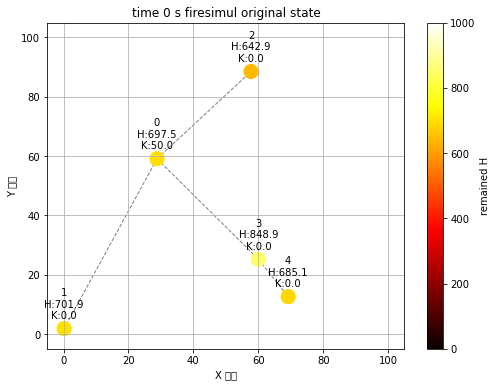

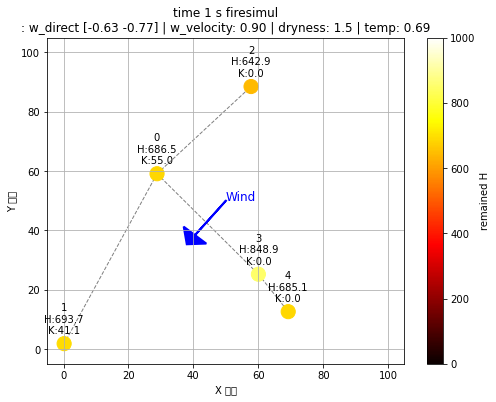

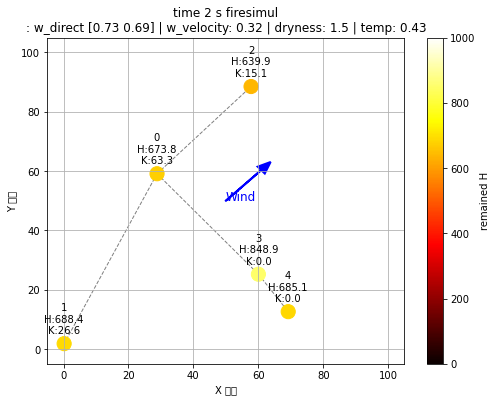

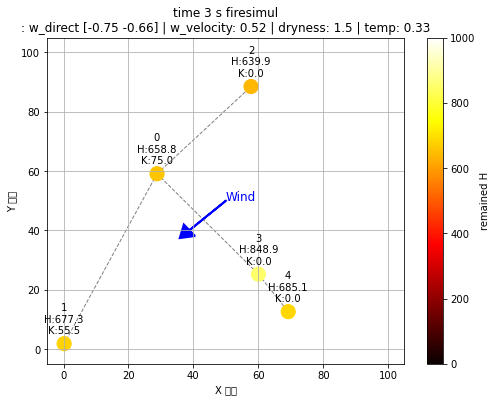

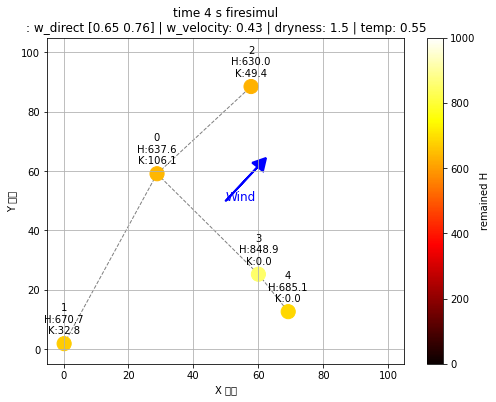

未找到时刻 6 的记录。
未找到时刻 7 的记录。
未找到时刻 8 的记录。
未找到时刻 9 的记录。
未找到时刻 10 的记录。
未找到时刻 11 的记录。


In [164]:
# 绘制时刻 t=10 的模拟结果
sim.plot_at_t(0)
sim.plot_at_t(1)
sim.plot_at_t(2)
sim.plot_at_t(3)
sim.plot_at_t(4)
sim.plot_at_t(6)
sim.plot_at_t(7)
sim.plot_at_t(8)
sim.plot_at_t(9)
sim.plot_at_t(10)
sim.plot_at_t(11)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_states(sim):
    """
    以 3D 散点图的形式将模拟历史中所有时刻的状态绘制出来，
    x-y 表示区域的二维位置，z 表示时间 t，
    每个点的颜色代表当前时刻该区域的剩余燃料 H。
    参数：
        sim: 模拟对象，其 history 属性包含了各时刻的状态记录
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 遍历历史中所有时刻
    for rec in sim.history:
        t, env_factors, state = rec
        xs, ys, zs, cs = [], [], [], []
        for node_id, info in state.items():
            xs.append(info['pos'][0])
            ys.append(info['pos'][1])
            zs.append(t)   # t作为z轴的坐标
            cs.append(info['H'])
        # 绘制当前时刻的散点，散点的颜色表示 H 值（固定色条范围）
        ax.scatter(xs, ys, zs, c=cs, cmap='hot', vmin=0, vmax=1000, s=50)
    
    ax.set_xlabel("X 坐标")
    ax.set_ylabel("Y 坐标")
    ax.set_zlabel("Time")
    ax.set_title("3D Plot of Simulation States over Time")
    
    # 添加颜色条（针对最后一组散点即可）
    mappable = plt.cm.ScalarMappable(cmap='hot')
    mappable.set_clim(0, 1000)
    fig.colorbar(mappable, ax=ax, label="剩余 H")
    
    plt.show()



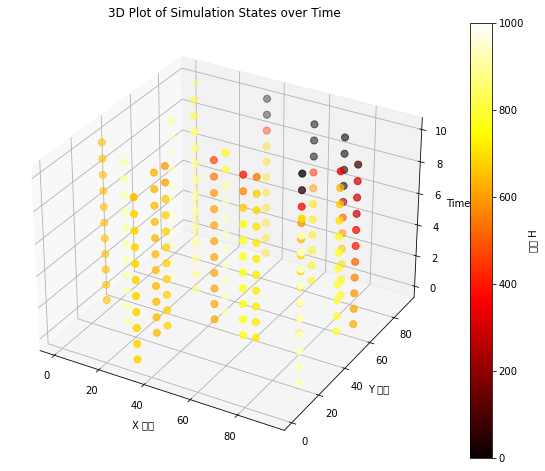

In [220]:
plot_3d_states(sim)

In [154]:
a,b,c,d = [1,2,3,4]
a

1

In [167]:
-np.log([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.0001])*2

array([ 4.60517019,  4.60517019,  4.60517019,  4.60517019,  4.60517019,
        4.60517019,  4.60517019,  4.60517019,  4.60517019, 18.42068074])